In [1]:
import numpy as np
import sklearn 
import tensorflow as tf

import splitfolders

import keras
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Activation, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

from sklearn.metrics import confusion_matrix 

import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # allow multiple outputs in a cell
import warnings
warnings.filterwarnings("ignore")

## **Image-data preparation**

In [3]:
input_folder = "../data/asl_dataset/"
output = "../data"

# splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1)) # train/val/test ratio

In [4]:
train_path = "../data/train"
valid_path = "../data/valid"
test_path = "../data/test"

In [5]:
%ls "../data/train" | wc -l

36


In [6]:
# batches of normalized , encoded data 
train_batches = ImageDataGenerator(rotation_range =20 ,
                         shear_range=0.35,
                         zoom_range=0.1,
                         vertical_flip=True) \
                         .flow_from_directory(train_path, 
                                             target_size=(224, 224),
                                             color_mode = "rgb",
                                             #classes=, 
                                             batch_size=256
                                            )
    
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224, 224),
                                                         #classes=,
                                                         batch_size=32
                                                        )

test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                        target_size=(224, 224),
                                                        #classes=,
                                                        batch_size=32
                                                       )

Found 2012 images belonging to 36 classes.
Found 251 images belonging to 36 classes.
Found 252 images belonging to 36 classes.


In [7]:
# import plots module

def plots(ims, figsize=(15,10), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [8]:
imgs, labels = next(train_batches)

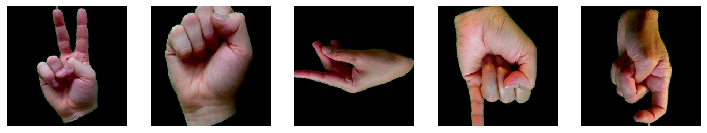

In [9]:
plots(imgs[:5])#, titles=labels)

## **Build and Train fine-tuned VGG16 model**

In [10]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

2022-09-22 00:14:23.806935: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-22 00:14:23.806984: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: skirui-HP-Z8-G4-Workstation
2022-09-22 00:14:23.806992: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: skirui-HP-Z8-G4-Workstation
2022-09-22 00:14:23.807148: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-09-22 00:14:23.807178: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-09-22 00:14:23.807186: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-09-22 00:14:23.808337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU i

In [11]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
type(vgg16_model)

keras.engine.functional.Functional

In [13]:
model = keras.Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [15]:
model.pop()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [17]:
for layer in model.layers:
    layer.trainable = False # avoid updating weights of layers, stick to pretained 

In [18]:
model.add(Dense(36, activation = "softmax"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [21]:
model.compile(Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit_generator(train_batches, steps_per_epoch=8, validation_data=valid_batches, \
                        validation_steps=8, epochs=5, verbose=2)

Epoch 1/5
8/8 - 107s - loss: 4.2622 - accuracy: 0.0437 - val_loss: 3.7363 - val_accuracy: 0.0837 - 107s/epoch - 13s/step
Epoch 2/5
8/8 - 107s - loss: 3.5504 - accuracy: 0.0755 - val_loss: 3.3168 - val_accuracy: 0.1355 - 107s/epoch - 13s/step
Epoch 3/5
8/8 - 106s - loss: 3.1790 - accuracy: 0.1302 - val_loss: 2.9617 - val_accuracy: 0.1793 - 106s/epoch - 13s/step
Epoch 4/5


## **Predict using fine-tuned VGG16 model**

In [ ]:
test_images, test_labels = next(test_batches)
plots(test_images[:5])#, titles=test_labels)

In [ ]:
test_labels = test_labels[:,0]
test_labels

In [ ]:
predictions = model.predict_generator(test_batches, steps=, verbose=2)

In [ ]:
cm = confusion_matrix(test_labels, np.round(predictions[;0]))